optuna-dashboard 起動メモ\
!hostname -i\
!optuna-dashboard --host "172.17.0.2"  "sqlite:///MachineLearning/OptunaLogs/2022-10-23/optuna.sqlite3"

In [42]:
!optuna studies --storage "sqlite:///./OptunaLogs/2022-10-24/optuna.sqlite3"

+----------------------------------------------+---------------+----------+---------------------+
| name                                         | direction     | n_trials | datetime_start      |
+----------------------------------------------+---------------+----------+---------------------+
| no-name-4f6c4edc-7462-436f-a771-2fb0d15ddb55 | ('MINIMIZE',) |        3 | 2022-10-24 05:03:23 |
| no-name-333187b0-177e-44a6-bb90-34158c100e9c | ('MINIMIZE',) |        3 | 2022-10-24 05:03:38 |
| no-name-cd45d0cd-f5b4-4c97-8d47-6cd5bb266561 | ('MINIMIZE',) |        3 | 2022-10-24 05:05:11 |
| no-name-ccf3f172-71e4-42e2-9bf1-d9c6dbe90dd6 | ('MINIMIZE',) |        3 | 2022-10-24 05:23:18 |
| no-name-4f9a4f6b-e21c-4c9d-8a64-d3ef1cd66f6d | ('MINIMIZE',) |        3 | 2022-10-24 05:23:31 |
| no-name-2e1c62fa-19bb-435e-ab04-00966bbf4755 | ('MINIMIZE',) |        3 | 2022-10-24 05:25:18 |
| no-name-4642f87f-da4b-45f9-87cf-b5e8a7f5bc9b | ('MAXIMIZE',) |        5 | 2022-10-24 06:42:33 |
| no-name-f48b5c51-1

# データの読み込み

In [1]:
!pwd

/mnt/MachineLearning/MLTrial


In [2]:
#warningはpythonの標準ライブラリ．
#FutureWarnigが邪魔なので非表示にする．動作に支障が無ければ問題ない．また最適化によって解が収束しないときに出るConvergenceWarningも邪魔なので非表示にする．
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=(FutureWarning, ConvergenceWarning))#対象のwarningsクラスはタプルで渡す必要があるらしい

In [3]:
import pprint
import sys
sys.path.append("/mnt/MachineLearning")
pprint.pprint(sys.path)

['/mnt/MachineLearning/MLTrial',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/mnt/MachineLearning']


In [4]:
#各種モジュールのimport
%matplotlib inline
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap

from modules import show_mod
from modules.log_controler import ControlLog

from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import mean_squared_error

import optuna

In [5]:
#読み込むデータのパスの設定
current_dir_path = os.getcwd()
data_path = "/mnt/MachineLearning/data"
input_list = glob.glob(data_path+"/*"+"/inputdata.csv")
output_list = glob.glob(data_path+"/CountResults"+"/sitting"+"/count_from2sec_patientAverage.csv")
num_input = len(input_list)

In [6]:
data_path

'/mnt/MachineLearning/data'

In [7]:
#input(空調条件等)の読み込み
df_input = None

for input_fname in input_list:
    df_read = pd.read_csv(input_fname, index_col="case_name")
    if df_input is None:
        df_input = df_read
    else:
        df_input = df_input.append(df_read)

df_input

,aircon,ventilation,exhaust,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,...,4_z,4_angle,5_x,5_y,5_z,5_angle,office_size_x,office_size_y,aircon_position_x,aircon_position_y
case_name,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,b,3.57,4.235,1.255,270.0,5.02,4.235,1.255,...,1.255,90.0,5.63,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_246_aout,660,246,a,3.57,4.235,1.255,270.0,5.02,4.235,1.255,...,1.255,90.0,5.63,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_82_bout,660,82,b,3.57,4.235,1.255,270.0,5.02,4.235,1.255,...,1.255,90.0,5.63,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_82_aout,660,82,a,3.57,4.235,1.255,270.0,5.02,4.235,1.255,...,1.255,90.0,5.63,2.315,1.255,90.0,8.5,6.5,4.25,3.25
office22_660_164_bout,660,164,b,3.57,4.235,1.255,270.0,5.02,4.235,1.255,...,1.255,90.0,5.63,2.315,1.255,90.0,8.5,6.5,4.25,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office2_960_164_bout,960,164,b,3.78,1.265,1.255,90.0,4.76,2.740,1.255,...,1.255,0.0,2.84,3.140,1.255,0.0,6.0,5.5,3.00,2.75
office2_360_246_aout,360,246,a,3.78,1.265,1.255,90.0,4.76,2.740,1.255,...,1.255,0.0,2.84,3.140,1.255,0.0,6.0,5.5,3.00,2.75
office2_360_164_bout,360,164,b,3.78,1.265,1.255,90.0,4.76,2.740,1.255,...,1.255,0.0,2.84,3.140,1.255,0.0,6.0,5.5,3.00,2.75


In [8]:
#入力データの選択(オフィスサイズとエアコン位置が被っていると思うので削除)
delete_cols = ["aircon_position_x", "aircon_position_y"]
df_input.drop(df_input[delete_cols], axis=1, inplace=True)
df_input

,aircon,ventilation,exhaust,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,...,4_x,4_y,4_z,4_angle,5_x,5_y,5_z,5_angle,office_size_x,office_size_y
case_name,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,b,3.57,4.235,1.255,270.0,5.02,4.235,1.255,...,4.18,2.315,1.255,90.0,5.63,2.315,1.255,90.0,8.5,6.5
office22_660_246_aout,660,246,a,3.57,4.235,1.255,270.0,5.02,4.235,1.255,...,4.18,2.315,1.255,90.0,5.63,2.315,1.255,90.0,8.5,6.5
office22_660_82_bout,660,82,b,3.57,4.235,1.255,270.0,5.02,4.235,1.255,...,4.18,2.315,1.255,90.0,5.63,2.315,1.255,90.0,8.5,6.5
office22_660_82_aout,660,82,a,3.57,4.235,1.255,270.0,5.02,4.235,1.255,...,4.18,2.315,1.255,90.0,5.63,2.315,1.255,90.0,8.5,6.5
office22_660_164_bout,660,164,b,3.57,4.235,1.255,270.0,5.02,4.235,1.255,...,4.18,2.315,1.255,90.0,5.63,2.315,1.255,90.0,8.5,6.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office2_960_164_bout,960,164,b,3.78,1.265,1.255,90.0,4.76,2.740,1.255,...,2.84,4.590,1.255,0.0,2.84,3.140,1.255,0.0,6.0,5.5
office2_360_246_aout,360,246,a,3.78,1.265,1.255,90.0,4.76,2.740,1.255,...,2.84,4.590,1.255,0.0,2.84,3.140,1.255,0.0,6.0,5.5
office2_360_164_bout,360,164,b,3.78,1.265,1.255,90.0,4.76,2.740,1.255,...,2.84,4.590,1.255,0.0,2.84,3.140,1.255,0.0,6.0,5.5


In [9]:
#排気口位置a,b,offをダミー変数化
df_input = pd.get_dummies(df_input, columns=['exhaust'])
df_input

,aircon,ventilation,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,...,4_angle,5_x,5_y,5_z,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
case_name,,,,,,,,,,,,,,,,,,,,,
office22_360_164_bout,360,164,3.57,4.235,1.255,270.0,5.02,4.235,1.255,270.0,...,90.0,5.63,2.315,1.255,90.0,8.5,6.5,0,1,0
office22_660_246_aout,660,246,3.57,4.235,1.255,270.0,5.02,4.235,1.255,270.0,...,90.0,5.63,2.315,1.255,90.0,8.5,6.5,1,0,0
office22_660_82_bout,660,82,3.57,4.235,1.255,270.0,5.02,4.235,1.255,270.0,...,90.0,5.63,2.315,1.255,90.0,8.5,6.5,0,1,0
office22_660_82_aout,660,82,3.57,4.235,1.255,270.0,5.02,4.235,1.255,270.0,...,90.0,5.63,2.315,1.255,90.0,8.5,6.5,1,0,0
office22_660_164_bout,660,164,3.57,4.235,1.255,270.0,5.02,4.235,1.255,270.0,...,90.0,5.63,2.315,1.255,90.0,8.5,6.5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office2_960_164_bout,960,164,3.78,1.265,1.255,90.0,4.76,2.740,1.255,180.0,...,0.0,2.84,3.140,1.255,0.0,6.0,5.5,0,1,0
office2_360_246_aout,360,246,3.78,1.265,1.255,90.0,4.76,2.740,1.255,180.0,...,0.0,2.84,3.140,1.255,0.0,6.0,5.5,1,0,0
office2_360_164_bout,360,164,3.78,1.265,1.255,90.0,4.76,2.740,1.255,180.0,...,0.0,2.84,3.140,1.255,0.0,6.0,5.5,0,1,0


In [10]:
df_output = pd.read_csv(output_list[0], index_col="casename")
df_output

,num_drop,volume[ml],RoI
casename,,,
office2_0_0,6739.4,0.000067,204.224242
office2_0_164_aout,7865.4,0.000063,238.345455
office2_0_164_bout,6049.8,0.000062,183.327273
office2_0_246_aout,7934.4,0.000050,240.436364
office2_0_246_bout,7662.0,0.000082,232.181818
...,...,...,...
office3_960_164_bout,5117.4,0.000075,155.072727
office3_960_246_aout,4428.0,0.000073,134.181818
office3_960_246_bout,3890.0,0.000066,117.878788


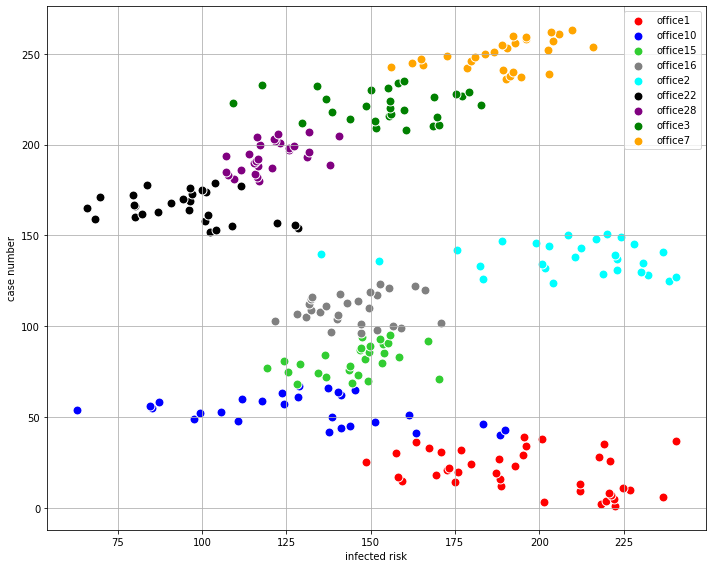

In [11]:
#df_outputの値の幅を見てみる
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_output.index.str.extract("(office+[0-9]{1,2})").to_numpy()

plt.figure(figsize=[10, 8])

#カラーマップ等の準備
markers = ("s", "x", "o", "^", "v", "<", ">", "1", "2", "3", "4", "8")
colors = ("red", "blue", "limegreen", "gray", "cyan", "black", "purple", "green",
          "orange", "yellow", "crimson", "goldenrod", "orchid")
start_index = 0

for idx, target_office_name in enumerate(np.unique(office_list)):
    target_office_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == target_office_name)]
    plt.scatter(df_output.iloc[target_office_index ,2], range(1+start_index, len(target_office_index)+1+start_index), 
                s=80, c=colors[idx], marker=markers[2], edgecolor="white", label=target_office_name)
    start_index += len(target_office_index)
    

plt.ylabel("case number")
plt.xlabel("infected risk")
plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

In [12]:
df_total = pd.merge(df_input, df_output, left_index=True, right_index=True)
print(f"num null in df:{df_total.isnull().values.sum()}")#結合が上手く行っていないかどうか確認
df_total

num null in df:0


,aircon,ventilation,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,...,5_z,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off,num_drop,volume[ml],RoI
office22_360_164_bout,360,164,3.57,4.235,1.255,270.0,5.02,4.235,1.255,270.0,...,1.255,90.0,8.5,6.5,0,1,0,5629.6,0.000047,101.893213
office22_660_246_aout,660,246,3.57,4.235,1.255,270.0,5.02,4.235,1.255,270.0,...,1.255,90.0,8.5,6.5,1,0,0,5321.0,0.000041,96.307692
office22_660_82_bout,660,82,3.57,4.235,1.255,270.0,5.02,4.235,1.255,270.0,...,1.255,90.0,8.5,6.5,0,1,0,4394.8,0.000048,79.543891
office22_660_82_aout,660,82,3.57,4.235,1.255,270.0,5.02,4.235,1.255,270.0,...,1.255,90.0,8.5,6.5,1,0,0,3848.2,0.000035,69.650679
office22_660_164_bout,660,164,3.57,4.235,1.255,270.0,5.02,4.235,1.255,270.0,...,1.255,90.0,8.5,6.5,0,1,0,5014.6,0.000059,90.761991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office2_960_164_bout,960,164,3.78,1.265,1.255,90.0,4.76,2.740,1.255,180.0,...,1.255,0.0,6.0,5.5,0,1,0,6232.4,0.000085,188.860606
office2_360_246_aout,360,246,3.78,1.265,1.255,90.0,4.76,2.740,1.255,180.0,...,1.255,0.0,6.0,5.5,1,0,0,6624.0,0.000051,200.727273
office2_360_164_bout,360,164,3.78,1.265,1.255,90.0,4.76,2.740,1.255,180.0,...,1.255,0.0,6.0,5.5,0,1,0,6021.0,0.000072,182.454545
office2_660_0,660,0,3.78,1.265,1.255,90.0,4.76,2.740,1.255,180.0,...,1.255,0.0,6.0,5.5,0,0,1,6954.2,0.000058,210.733333


In [13]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, office22_360_164_bout to office2_360_82_bout
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   aircon         263 non-null    int64  
 1   ventilation    263 non-null    int64  
 2   1_x            263 non-null    float64
 3   1_y            263 non-null    float64
 4   1_z            263 non-null    float64
 5   1_angle        263 non-null    float64
 6   2_x            263 non-null    float64
 7   2_y            263 non-null    float64
 8   2_z            263 non-null    float64
 9   2_angle        263 non-null    float64
 10  3_x            263 non-null    float64
 11  3_y            263 non-null    float64
 12  3_z            263 non-null    float64
 13  3_angle        263 non-null    float64
 14  4_x            263 non-null    float64
 15  4_y            263 non-null    float64
 16  4_z            263 non-null    float64
 17  4_angle        263 non-

# 統計分析

In [14]:
#基礎統計量について確認
df_total.describe()

,aircon,ventilation,1_x,1_y,1_z,1_angle,2_x,2_y,2_z,2_angle,...,5_z,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off,num_drop,volume[ml],RoI
count,263.000000,263.000000,263.000000,263.000000,2.630000e+02,263.000000,263.000000,263.000000,2.630000e+02,263.000000,...,2.630000e+02,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,501.673004,139.368821,3.585490,2.672395,1.255000e+00,84.182510,4.044833,3.156700,1.255000e+00,183.764259,...,1.255000e+00,99.581749,7.490494,5.553232,0.433460,0.433460,0.133080,6166.290494,0.000066,155.318244
std,363.998489,83.668403,2.005094,1.089624,4.449359e-16,99.137487,1.122817,0.581813,4.449359e-16,111.556876,...,4.449359e-16,77.248829,1.372753,0.671829,0.496497,0.496497,0.340309,1015.752570,0.000017,40.755902
min,0.000000,0.000000,1.250000,0.940000,1.255000e+00,0.000000,2.930000,2.390000,1.255000e+00,0.000000,...,1.255000e+00,0.000000,6.000000,4.000000,0.000000,0.000000,0.000000,2644.400000,0.000025,62.961905
25%,0.000000,82.000000,1.266000,2.180000,1.255000e+00,0.000000,3.140000,2.740000,1.255000e+00,90.000000,...,1.255000e+00,90.000000,6.000000,5.500000,0.000000,0.000000,0.000000,5563.700000,0.000056,126.538596
50%,660.000000,164.000000,3.570000,2.505000,1.255000e+00,0.000000,3.285000,3.059000,1.255000e+00,270.000000,...,1.255000e+00,90.000000,7.000000,5.500000,0.000000,0.000000,0.000000,6232.400000,0.000066,151.884444
75%,960.000000,246.000000,4.760000,3.820000,1.255000e+00,180.000000,5.016000,3.485000,1.255000e+00,270.000000,...,1.255000e+00,90.000000,9.000000,6.000000,1.000000,1.000000,0.000000,6928.900000,0.000076,188.174242
max,960.000000,246.000000,7.735000,4.235000,1.255000e+00,270.000000,6.260000,4.235000,1.255000e+00,270.000000,...,1.255000e+00,270.000000,9.500000,6.500000,1.000000,1.000000,1.000000,8008.600000,0.000130,240.466667


In [15]:
#口のz座標は全て同じであることがわかり特徴量として機能しないので削除
delete_cols = ["1_z","2_z","3_z","4_z","5_z"]
df_total.drop(df_total[delete_cols], axis=1, inplace=True)
df_total

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off,num_drop,volume[ml],RoI
office22_360_164_bout,360,164,3.57,4.235,270.0,5.02,4.235,270.0,2.73,2.315,...,2.315,90.0,8.5,6.5,0,1,0,5629.6,0.000047,101.893213
office22_660_246_aout,660,246,3.57,4.235,270.0,5.02,4.235,270.0,2.73,2.315,...,2.315,90.0,8.5,6.5,1,0,0,5321.0,0.000041,96.307692
office22_660_82_bout,660,82,3.57,4.235,270.0,5.02,4.235,270.0,2.73,2.315,...,2.315,90.0,8.5,6.5,0,1,0,4394.8,0.000048,79.543891
office22_660_82_aout,660,82,3.57,4.235,270.0,5.02,4.235,270.0,2.73,2.315,...,2.315,90.0,8.5,6.5,1,0,0,3848.2,0.000035,69.650679
office22_660_164_bout,660,164,3.57,4.235,270.0,5.02,4.235,270.0,2.73,2.315,...,2.315,90.0,8.5,6.5,0,1,0,5014.6,0.000059,90.761991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office2_960_164_bout,960,164,3.78,1.265,90.0,4.76,2.740,180.0,4.76,4.190,...,3.140,0.0,6.0,5.5,0,1,0,6232.4,0.000085,188.860606
office2_360_246_aout,360,246,3.78,1.265,90.0,4.76,2.740,180.0,4.76,4.190,...,3.140,0.0,6.0,5.5,1,0,0,6624.0,0.000051,200.727273
office2_360_164_bout,360,164,3.78,1.265,90.0,4.76,2.740,180.0,4.76,4.190,...,3.140,0.0,6.0,5.5,0,1,0,6021.0,0.000072,182.454545
office2_660_0,660,0,3.78,1.265,90.0,4.76,2.740,180.0,4.76,4.190,...,3.140,0.0,6.0,5.5,0,0,1,6954.2,0.000058,210.733333


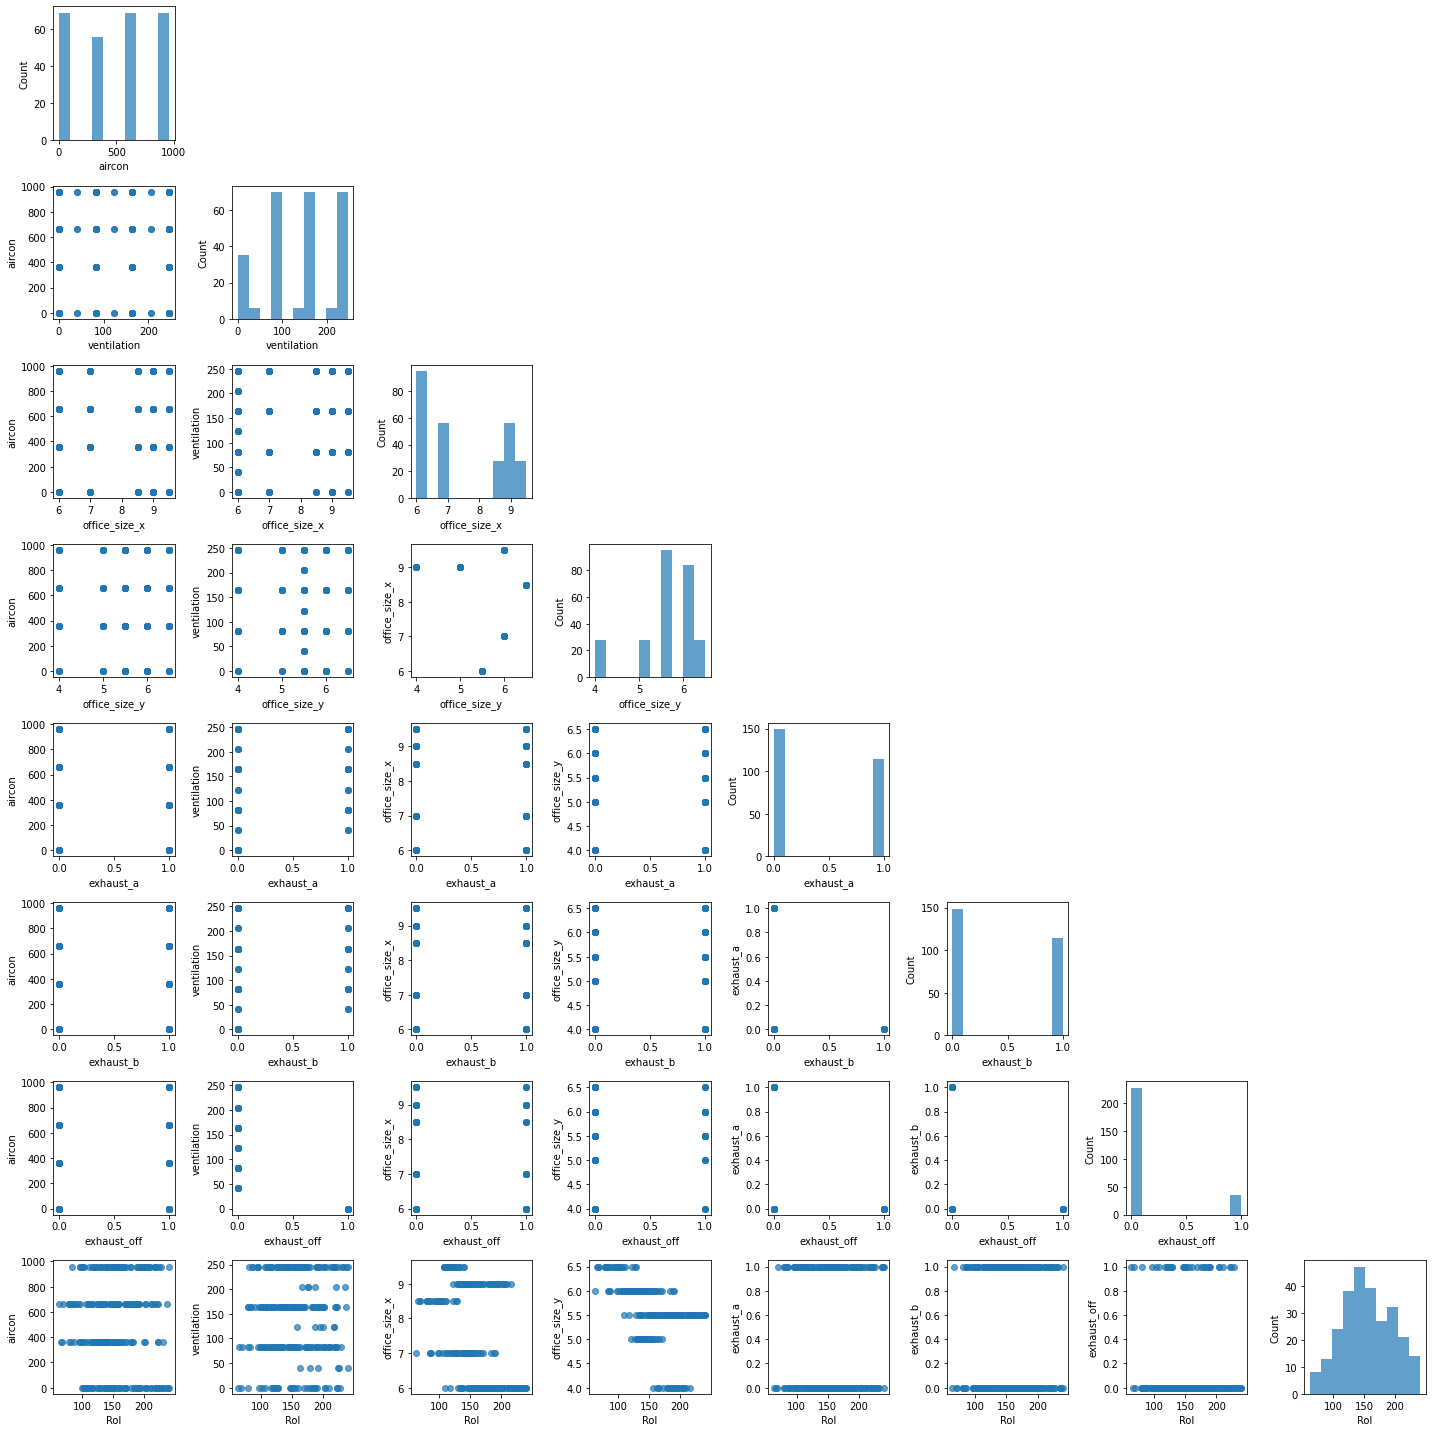

In [16]:
plot_cols = ["aircon", "ventilation", "office_size_x", "office_size_y", "exhaust_a", "exhaust_b", "exhaust_off", "RoI"]
# plot_cols = ['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y',"RoI"]
# plot_cols = ['1_angle','2_angle','3_angle','4_angle','5_angle',"RoI"]
scatterplotmatrix(df_total[plot_cols].values, figsize=(20, 20), names=plot_cols, alpha=0.7)
plt.tight_layout()
plt.show()

外れ値の確認などもここで行っておくとよい．

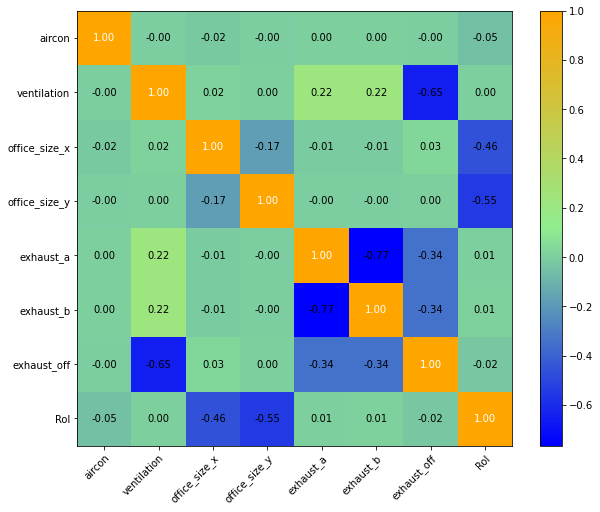

In [17]:
#ピアソンの積率相関係数のヒートマップ（ピアソンの積率相関係数はスケーリングした共分散）
cmap = show_mod.make_colormap(["blue", "lightgreen", "orange"])
correlationcoefficient = df_total[plot_cols].corr().to_numpy()
heat_map = heatmap(correlationcoefficient, figsize=(10, 8), cmap=cmap, row_names=plot_cols, column_names=plot_cols)
plt.show()

# データの前処理 

In [18]:
#説明変数と目的変数の定義
explanatory_variable =['aircon', 'ventilation', '1_x', '1_y', '1_angle', '2_x', '2_y',
                       '2_angle', '3_x', '3_y', '3_angle', '4_x', '4_y', '4_angle', '5_x', '5_y', '5_angle',
                       'office_size_x','office_size_y', 'exhaust_a', 'exhaust_b', 'exhaust_off']
objective_variable = ["RoI"]

df_explanatory_variable = df_total[explanatory_variable]
df_objective_variable = df_total[objective_variable]

**標準化について**\
scikit-learnによる線型回帰では勾配降下法に基づく最適化を行わず，scipyの最小二乗法の実装に使用されているLAPACKに基づく高度な最適化手法を利用している．\
そのため使用する変数を標準化する必要がなく，寧ろ標準化しない方が上手く行くらしい．\
勾配降下法適用時に標準化する理由としては特徴量をスケーリングすることで，各特徴量に基づくパラメータ更新幅を揃えることができ，\
結果として誤差関数の収束が早くなったりする．\
標準化を行うべきかどうかは，用いる機械学習アルゴリズムによって異なるため，その都度考える必要がある．

In [19]:
#説明変数の標準化(only explanatory variable)
#目的変数は標準化する意味がないため，するべきではない．
stdscaler = preprocessing.StandardScaler()
stdscaler.fit(df_explanatory_variable)
np_explanatory_variable_std = stdscaler.transform(df_explanatory_variable)
df_explanatory_variable_std = pd.DataFrame(np_explanatory_variable_std, index=df_explanatory_variable.index, columns=df_explanatory_variable.columns)
df_explanatory_variable_std

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,4_y,4_angle,5_x,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
office22_360_164_bout,-0.389955,0.294952,-0.007740,1.436811,1.877915,0.870156,1.856880,0.774494,-0.698828,-1.71394,...,-0.134961,-0.124274,2.054556,0.247300,-0.124274,0.73679,1.411927,-0.874700,1.143249,-0.391802
office22_660_246_aout,0.435795,1.276880,-0.007740,1.436811,1.877915,0.870156,1.856880,0.774494,-0.698828,-1.71394,...,-0.134961,-0.124274,2.054556,0.247300,-0.124274,0.73679,1.411927,1.143249,-0.874700,-0.391802
office22_660_82_bout,0.435795,-0.686976,-0.007740,1.436811,1.877915,0.870156,1.856880,0.774494,-0.698828,-1.71394,...,-0.134961,-0.124274,2.054556,0.247300,-0.124274,0.73679,1.411927,-0.874700,1.143249,-0.391802
office22_660_82_aout,0.435795,-0.686976,-0.007740,1.436811,1.877915,0.870156,1.856880,0.774494,-0.698828,-1.71394,...,-0.134961,-0.124274,2.054556,0.247300,-0.124274,0.73679,1.411927,1.143249,-0.874700,-0.391802
office22_660_164_bout,0.435795,0.294952,-0.007740,1.436811,1.877915,0.870156,1.856880,0.774494,-0.698828,-1.71394,...,-0.134961,-0.124274,2.054556,0.247300,-0.124274,0.73679,1.411927,-0.874700,1.143249,-0.391802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office2_960_164_bout,1.261546,0.294952,0.097193,-1.294097,0.058793,0.638155,-0.717575,-0.033807,0.775102,1.02123,...,1.638603,-1.291561,-0.075483,0.950827,-1.291561,-1.08784,-0.079385,-0.874700,1.143249,-0.391802
office2_360_246_aout,-0.389955,1.276880,0.097193,-1.294097,0.058793,0.638155,-0.717575,-0.033807,0.775102,1.02123,...,1.638603,-1.291561,-0.075483,0.950827,-1.291561,-1.08784,-0.079385,1.143249,-0.874700,-0.391802
office2_360_164_bout,-0.389955,0.294952,0.097193,-1.294097,0.058793,0.638155,-0.717575,-0.033807,0.775102,1.02123,...,1.638603,-1.291561,-0.075483,0.950827,-1.291561,-1.08784,-0.079385,-0.874700,1.143249,-0.391802
office2_660_0,0.435795,-1.668904,0.097193,-1.294097,0.058793,0.638155,-0.717575,-0.033807,0.775102,1.02123,...,1.638603,-1.291561,-0.075483,0.950827,-1.291561,-1.08784,-0.079385,-0.874700,-0.874700,2.552310


In [20]:
df_explanatory_variable
# df_explanatory_variable_std
# df_objective_variable

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,4_y,4_angle,5_x,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
office22_360_164_bout,360,164,3.57,4.235,270.0,5.02,4.235,270.0,2.73,2.315,...,2.315,90.0,5.63,2.315,90.0,8.5,6.5,0,1,0
office22_660_246_aout,660,246,3.57,4.235,270.0,5.02,4.235,270.0,2.73,2.315,...,2.315,90.0,5.63,2.315,90.0,8.5,6.5,1,0,0
office22_660_82_bout,660,82,3.57,4.235,270.0,5.02,4.235,270.0,2.73,2.315,...,2.315,90.0,5.63,2.315,90.0,8.5,6.5,0,1,0
office22_660_82_aout,660,82,3.57,4.235,270.0,5.02,4.235,270.0,2.73,2.315,...,2.315,90.0,5.63,2.315,90.0,8.5,6.5,1,0,0
office22_660_164_bout,660,164,3.57,4.235,270.0,5.02,4.235,270.0,2.73,2.315,...,2.315,90.0,5.63,2.315,90.0,8.5,6.5,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office2_960_164_bout,960,164,3.78,1.265,90.0,4.76,2.740,180.0,4.76,4.190,...,4.590,0.0,2.84,3.140,0.0,6.0,5.5,0,1,0
office2_360_246_aout,360,246,3.78,1.265,90.0,4.76,2.740,180.0,4.76,4.190,...,4.590,0.0,2.84,3.140,0.0,6.0,5.5,1,0,0
office2_360_164_bout,360,164,3.78,1.265,90.0,4.76,2.740,180.0,4.76,4.190,...,4.590,0.0,2.84,3.140,0.0,6.0,5.5,0,1,0
office2_660_0,660,0,3.78,1.265,90.0,4.76,2.740,180.0,4.76,4.190,...,4.590,0.0,2.84,3.140,0.0,6.0,5.5,0,0,1


**同じ形状のオフィス一覧**\
office1-6\
office7-9\
office10-15\
office16-21\
office22-27\
office28-33

In [21]:
#特定のofficeだけテストデータにする
target_office_name = ["office10"]
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = df_total.index.str.extract("(office+[0-9]{1,2})").to_numpy()
print(f"office list in data:\n{np.unique(office_list)}")
#リスト内包表記
test_data_index = [i for i in range(office_list.shape[0]) if any(office_list[i] == target_office_name)]
#test_data_index以外をtrain_data_indexとする
train_data_bool = np.ones(office_list.shape[0], dtype = bool)
train_data_bool[test_data_index] = False
train_data_index = np.arange(office_list.shape[0])[train_data_bool]

office list in data:
['office1' 'office10' 'office15' 'office16' 'office2' 'office22'
 'office28' 'office3' 'office7']


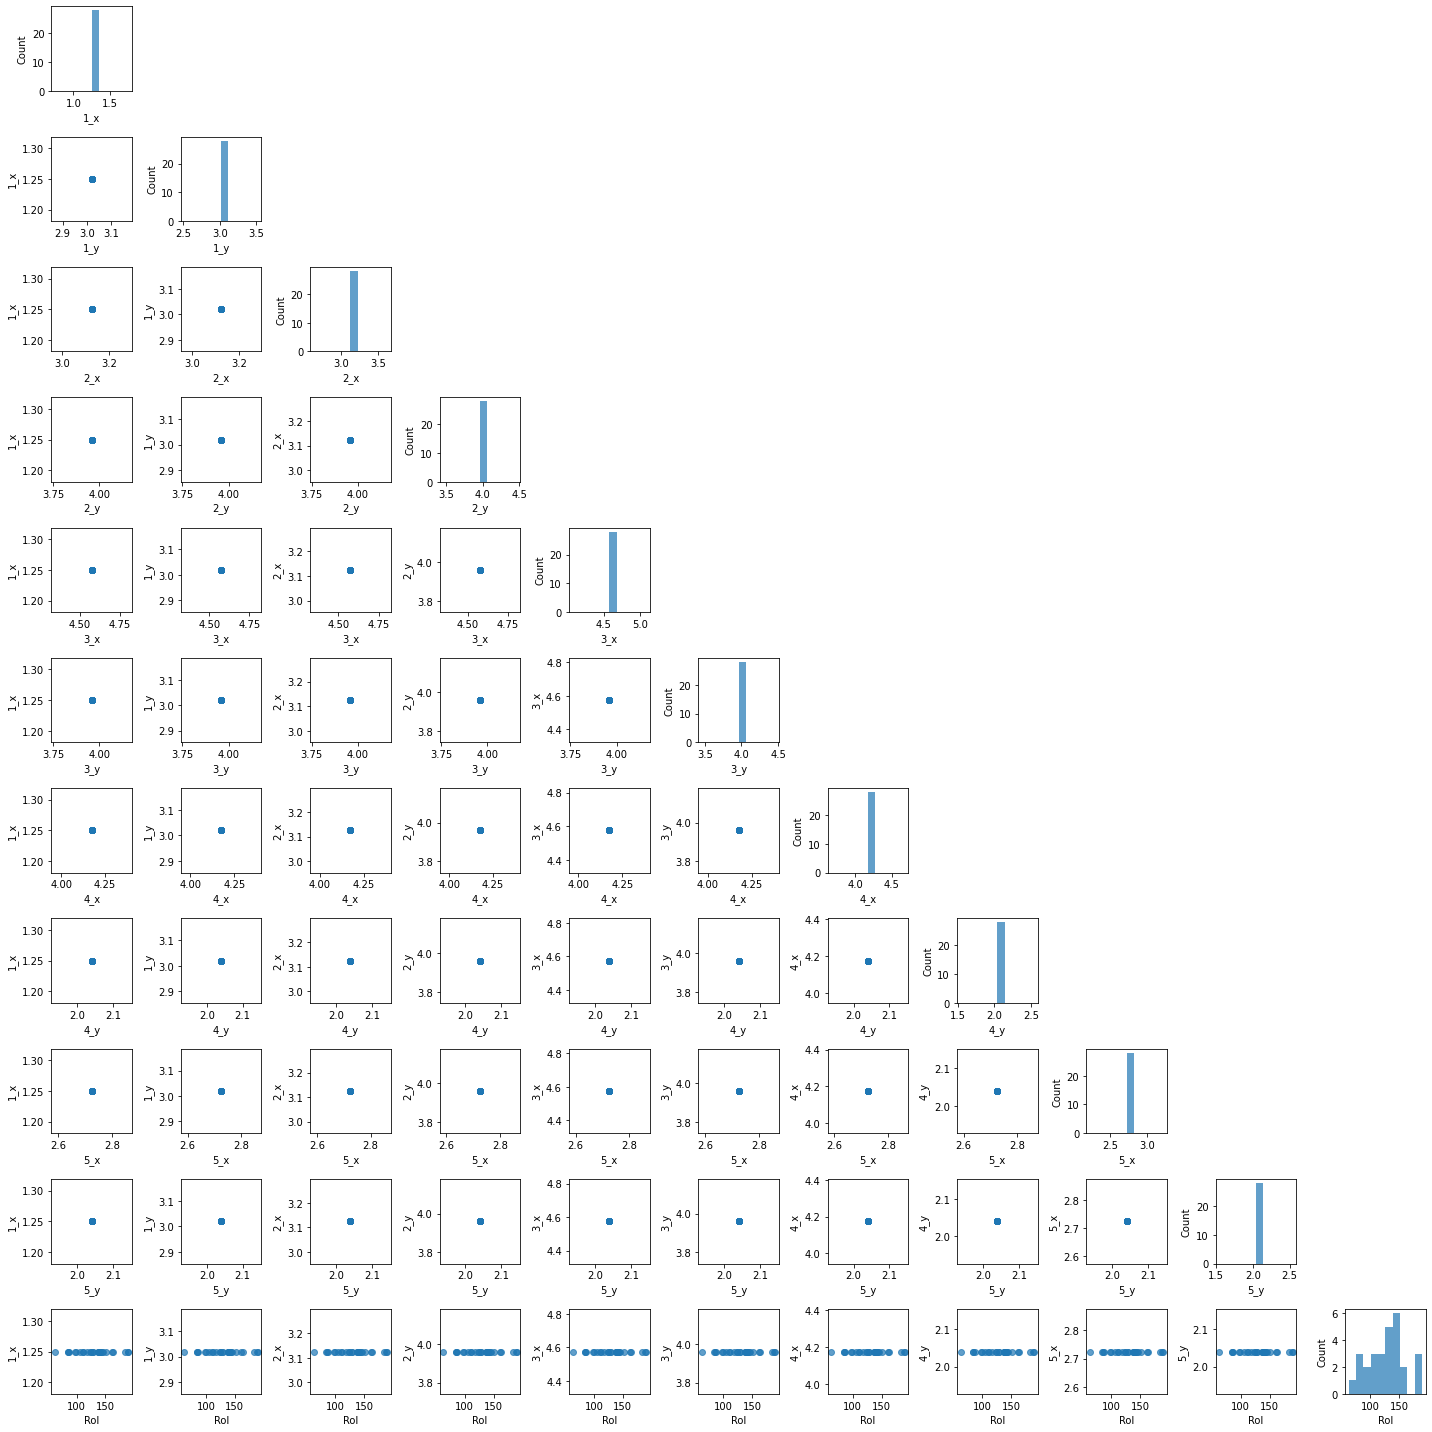

In [22]:
#各オフィスで分けて統計解析してみる(同じ形状のオフィスだけで関係を見たりしたいときに使う)
# plot_cols = ["aircon", "ventilation", "office_size_x", "office_size_y", "exhaust_a", "exhaust_b", "exhaust_off", "RoI"]
plot_cols = ['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y',"RoI"]
# plot_cols = ['1_angle','2_angle','3_angle','4_angle','5_angle',"RoI"]
df_target_office = df_total.iloc[test_data_index]
scatterplotmatrix(df_target_office[plot_cols].values, figsize=(20, 20), names=plot_cols, alpha=0.7)
plt.tight_layout()
plt.show()

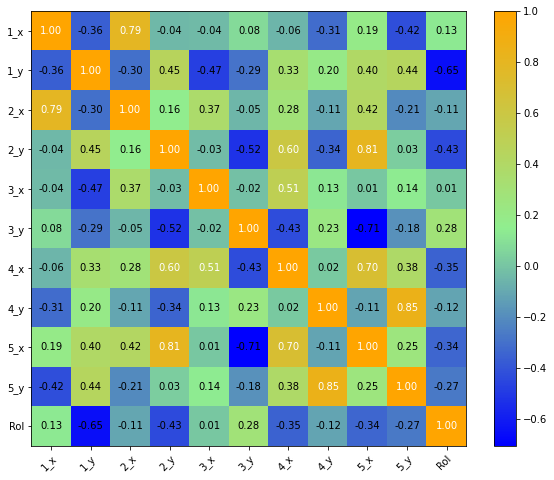

In [23]:
#ピアソンの積率相関係数のヒートマップ（ピアソンの積率相関係数はスケーリングした共分散）
cmap = show_mod.make_colormap(["blue", "lightgreen", "orange"])
correlationcoefficient = df_total[plot_cols].corr().to_numpy()
heat_map = heatmap(correlationcoefficient, figsize=(10, 8), cmap=cmap, row_names=plot_cols, column_names=plot_cols)
plt.show()

# 回帰分析

# 線形回帰（線形重回帰）

今回は説明変数の数が一つではないため単回帰ではなく，重回帰となる．

In [24]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]
test_explanatory_variable

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,4_y,4_angle,5_x,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
office10_360_164_bout,360,164,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,0,1,0
office10_660_246_aout,660,246,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,1,0,0
office10_660_82_bout,660,82,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,0,1,0
office10_660_82_aout,660,82,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,1,0,0
office10_660_164_bout,660,164,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,0,1,0
office10_0_164_aout,0,164,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,1,0,0
office10_0_82_aout,0,82,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,1,0,0
office10_660_164_aout,660,164,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,1,0,0
office10_660_246_bout,660,246,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,0,1,0
office10_360_246_bout,360,246,1.25,3.02,0.0,3.125,3.96,270.0,4.575,3.96,...,2.04,90.0,2.725,2.04,90.0,7.0,6.0,0,1,0


In [25]:
linear_model = LinearRegression()

In [26]:
#k分割交差検証の実装
#評価指標の決定
metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"]
#交差検証の分割方法を決定
kf = KFold(n_splits=10, shuffle=True, random_state=1)

scikit-learnによる交差検証では，よく"cross_val_score"が用いられるがこれは少し古く，\
現在は"cross_validate"というものがある．こちらではscoringにリストやタプル，辞書型を用いて複数の評価指標を与えることができる．\
まあfor文を使えばcross_val_scoreでも複数のscoringを使用することは簡単にできるけどね．

In [27]:
scores = cross_validate(estimator=linear_model, scoring=metrics,
                         X=train_explanatory_variable, y=train_objective_variable, 
                         cv=kf, n_jobs=1, verbose=1, return_train_score=True)
pprint.pprint(scores)

{'fit_time': array([0.00376415, 0.00280333, 0.00260139, 0.00249648, 0.00247788,
       0.0024755 , 0.00256467, 0.00241327, 0.00250435, 0.00253844]),
 'score_time': array([0.0036931 , 0.00343704, 0.00340652, 0.00337529, 0.00344729,
       0.00331044, 0.00344038, 0.00345969, 0.00319266, 0.00341725]),
 'test_neg_mean_absolute_error': array([-18.86806434, -14.81554729, -17.87584741, -18.98161881,
       -12.47855783, -12.46736388, -12.44517527, -13.54186473,
       -13.85848287,  -9.52867898]),
 'test_neg_mean_squared_error': array([-662.65495283, -345.38810331, -441.37159574, -544.46482069,
       -260.678254  , -233.97350081, -243.71391603, -290.28191758,
       -357.88017573, -137.76820965]),
 'test_r2': array([0.55640327, 0.81055749, 0.66477435, 0.73226475, 0.78713239,
       0.88936542, 0.77449607, 0.829544  , 0.76918961, 0.89892036]),
 'train_neg_mean_absolute_error': array([-12.89834364, -13.44256848, -13.14792194, -13.05736469,
       -13.7748678 , -13.79136539, -13.91062041, -13.5

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


n_jobsは使用するcpuの個数．これぐらいの軽い処理なら，分割せず1つでやった方が分割の処理に時間がかからないので逆に早い．

In [28]:
print("交差検証結果の平均値")
print("test_r2 score:", scores["test_r2"].mean())
print("test_neg_mean_squared_error:", scores["test_neg_mean_squared_error"].mean())
print("test_neg_mean_absolute_error:", scores["test_neg_mean_absolute_error"].mean())

交差検証結果の平均値
test_r2 score: 0.7712647704417991
test_neg_mean_squared_error: -351.8175446387262
test_neg_mean_absolute_error: -14.486120141822514


In [29]:
linear_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = linear_model.predict(train_explanatory_variable)
test_pred = linear_model.predict(test_explanatory_variable)

/mnt/MachineLearning/modules/show_mod.py:88: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


<Figure size 720x576 with 0 Axes>

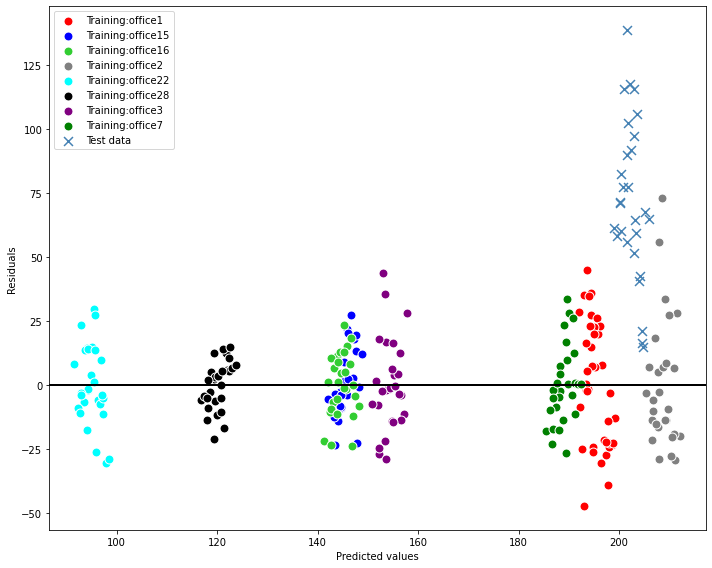

In [30]:
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()

#残差プロット
show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy(), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy(), 
                            office_list=office_list)

## Lasso回帰

Lassoは正則化の特徴からパラメータのスケールによってペナルティを与えるので標準化必須

In [31]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]
test_explanatory_variable
test_objective_variable

,RoI
office10_360_164_bout,97.747619
office10_660_246_aout,124.204762
office10_660_82_bout,111.785714
office10_660_82_aout,117.776190
office10_660_164_bout,84.561905
office10_0_164_aout,163.342857
office10_0_82_aout,143.985714
office10_660_164_aout,85.161905
office10_660_246_bout,87.109524
office10_360_246_bout,161.519048


In [32]:
#ラッソー回帰のインスタンス作成
lasso_model = Lasso(alpha=1.0)

In [33]:
#k分割交差検証の実装
#評価指標の決定
metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"]
#交差検証の分割方法を決定
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [34]:
scores = cross_validate(estimator=lasso_model, scoring=metrics,
                         X=train_explanatory_variable, y=train_objective_variable, 
                         cv=kf, n_jobs=1, verbose=1, return_train_score=True)
pprint.pprint(scores)

{'fit_time': array([0.00699568, 0.0027802 , 0.0022707 , 0.00221682, 0.00205684,
       0.0022006 , 0.00199842, 0.00204468, 0.00202942, 0.00206876]),
 'score_time': array([0.00567937, 0.00412822, 0.00336456, 0.00338531, 0.00335932,
       0.00332737, 0.00334048, 0.00320029, 0.00312328, 0.00322747]),
 'test_neg_mean_absolute_error': array([-18.50416596, -14.01802626, -17.4578031 , -18.66711402,
       -12.57458535, -13.75239809, -12.18658281, -14.24284097,
       -12.47403389,  -9.29986306]),
 'test_neg_mean_squared_error': array([-597.69450737, -338.57403911, -433.98401008, -530.86954463,
       -270.35285271, -303.28426409, -207.70581595, -327.04661775,
       -311.14675167, -137.68960974]),
 'test_r2': array([0.59988931, 0.81429495, 0.67038529, 0.73895009, 0.77923219,
       0.85659176, 0.80781369, 0.80795546, 0.79932976, 0.89897802]),
 'train_neg_mean_absolute_error': array([-13.02707073, -13.58629371, -13.24572967, -13.14167803,
       -13.85712475, -13.90840857, -13.9253208 , -13.7

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [35]:
print("交差検証結果の平均値")
print("test_r2 score:", scores["test_r2"].mean())
print("test_neg_mean_squared_error:", scores["test_neg_mean_squared_error"].mean())
print("test_neg_mean_absolute_error:", scores["test_neg_mean_absolute_error"].mean())

交差検証結果の平均値
test_r2 score: 0.7773420523412147
test_neg_mean_squared_error: -345.8348013100541
test_neg_mean_absolute_error: -14.317741352459404


In [36]:
lasso_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = lasso_model.predict(train_explanatory_variable)
test_pred = lasso_model.predict(test_explanatory_variable)
print(f"r2 train score:{lasso_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{lasso_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")

r2 train score:0.8081546312147075
MSE train score:316.21963360291574
r2 test score:-2.974338609779058
MSE test score:3871.4617176613347


/mnt/MachineLearning/modules/show_mod.py:88: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


<Figure size 720x576 with 0 Axes>

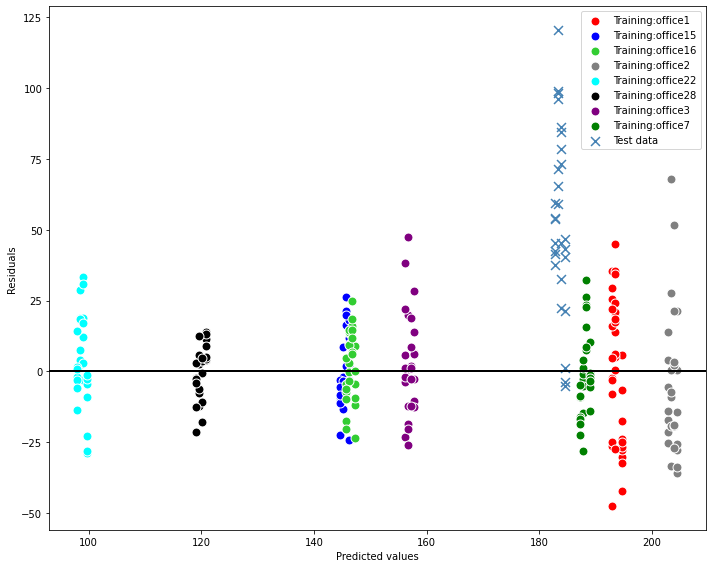

In [37]:
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()

show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy().reshape(-1), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy().reshape(-1), 
                            office_list=office_list)

### optunaと交差検証を使用したハイパーパラメータ調整（自動最適化）

In [38]:
class Objective:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        params = {
            "alpha" : trial.suggest_loguniform("alpha", 0.0001, 10),
            "max_iter" : trial.suggest_int("max_iter", 100, 100000)
        }
        
        #**keywardargs(可変個数の変数をkeyと共に与えられる)
        model = Lasso(**params)
        
        #最適化実行時の評価指標の決定
        metrics = ["r2"]
        
        #交差検証の分割方法を決定
        kf = KFold(n_splits=10, shuffle=True, random_state=1)
        
        #評価指標の決定，k分割交差検証の実装
        scores = cross_validate(estimator=model, scoring=metrics,
                         X=self.X, y=self.y, 
                         cv=kf, n_jobs=1, verbose=0, return_train_score=True)
        
        return scores["test_r2"].mean()
        
        #複数の目的関数を戻り値とする
#         return scores["test_r2"].mean(), scores["test_neg_mean_squared_error"].mean()

In [39]:
control_log = ControlLog()
sqlite_path = control_log.set_log()
study_name = control_log.decide_filename()
model_name = "Lasso"

#ハイパーパラメータの探索
objective = Objective(X=train_explanatory_variable, y=train_objective_variable)

#計算資源があるときはランダムサーチ，無ければTPESampler
#storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                            sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                            storage=sqlite_path, load_if_exists=True)

"""
複数の目的関数を持つときはmulti_objectiveモジュールを使用する
複数の目的関数を最適化するのは多目的最適化と呼ばれ，専用の最適化アルゴリズムを指定する必要がある．単一目的関数の場合と比較する必要があるかもしれない．
directionは目的関数がどうなるように最適化したいか．samplerが多目的最適化アルゴリズム．defaultはNSGAIIMultiObjectiveSampler
"""

# study = optuna.multi_objective.create_study(directions=["maximize", "minimize"],
#                                             sampler=optuna.multi_objective.samplers.NSGAIIMultiObjectiveSampler(seed=1), 
#                                             storage=sqlite_path, load_if_exists=True)

#最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
#n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
study.optimize(objective, n_trials=None, timeout=60, n_jobs=-1)

#ハンドラの削除．これを行わないとログファイルが上書きされる．
control_log.kill_handler()

SyntaxError: invalid character in identifier (3269807062.py, line 20)

In [45]:
#探索の結果最も良かったscore
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

best score: 0.7780738235797484
best params: {'alpha': 0.7412178350768697, 'max_iter': 45411}


r2 train score:0.8102062965638794
MSE train score:312.8378638521066
r2 test score:-3.0369675945531434
MSE test score:3932.4695332441


/mnt/MachineLearning/modules/show_mod.py:88: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


<Figure size 720x576 with 0 Axes>

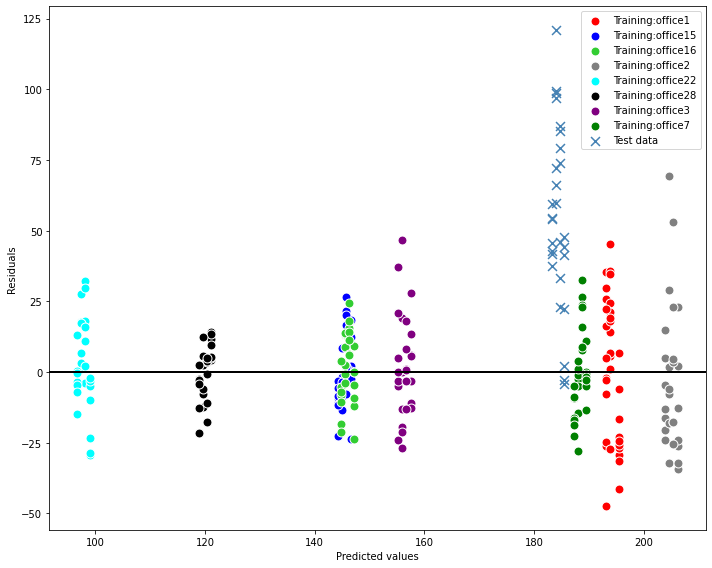

In [52]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価

best_model = Lasso(alpha=study.best_params["alpha"], max_iter=study.best_params["max_iter"])
best_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print(f"r2 train score:{best_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{best_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")


#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果の残差プロット
show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy().reshape(-1), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy().reshape(-1), 
                            office_list=office_list)

## Ridge回帰

In [56]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]
test_explanatory_variable
test_objective_variable

,RoI
office10_360_164_bout,97.747619
office10_660_246_aout,124.204762
office10_660_82_bout,111.785714
office10_660_82_aout,117.776190
office10_660_164_bout,84.561905
office10_0_164_aout,163.342857
office10_0_82_aout,143.985714
office10_660_164_aout,85.161905
office10_660_246_bout,87.109524
office10_360_246_bout,161.519048


In [57]:
#リッジ回帰のインスタンス作成
ridge_model = Ridge(alpha=1.0)

In [58]:
#k分割交差検証の実装
#評価指標の決定
metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"]
#交差検証の分割方法を決定
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [59]:
scores = cross_validate(estimator=ridge_model, scoring=metrics,
                         X=train_explanatory_variable, y=train_objective_variable, 
                         cv=kf, n_jobs=1, verbose=1, return_train_score=True)
pprint.pprint(scores)

{'fit_time': array([0.01027918, 0.00597334, 0.00397587, 0.00225496, 0.00218391,
       0.00214696, 0.0020082 , 0.00199485, 0.00201106, 0.00204349]),
 'score_time': array([0.00730205, 0.00916529, 0.00423479, 0.00345993, 0.00343704,
       0.00327969, 0.00340176, 0.00325227, 0.00322723, 0.00328445]),
 'test_neg_mean_absolute_error': array([-18.8719349 , -14.79384861, -17.84499846, -18.98274959,
       -12.46108708, -12.53072609, -12.41167022, -13.55909602,
       -13.80054607,  -9.53304462]),
 'test_neg_mean_squared_error': array([-660.66497533, -346.14508888, -440.1635978 , -545.30398682,
       -260.92682765, -236.52029203, -241.72224826, -290.68132247,
       -355.53062298, -138.19333787]),
 'test_r2': array([0.55773541, 0.81014229, 0.66569183, 0.7318521 , 0.7869294 ,
       0.88816116, 0.77633892, 0.82930947, 0.77070493, 0.89860844]),
 'train_neg_mean_absolute_error': array([-12.89405578, -13.44457919, -13.145557  , -13.05437038,
       -13.7730031 , -13.78229859, -13.90876565, -13.5

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [60]:
print("交差検証結果の平均値")
print("test_r2 score:", scores["test_r2"].mean())
print("test_neg_mean_squared_error:", scores["test_neg_mean_squared_error"].mean())
print("test_neg_mean_absolute_error:", scores["test_neg_mean_absolute_error"].mean())

交差検証結果の平均値
test_r2 score: 0.7715473959527066
test_neg_mean_squared_error: -351.5852300087469
test_neg_mean_absolute_error: -14.478970165926142


In [62]:
ridge_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = ridge_model.predict(train_explanatory_variable)
test_pred = ridge_model.predict(test_explanatory_variable)
print(f"r2 train score:{lasso_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{lasso_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")

r2 train score:0.8081546312147075
MSE train score:308.14338131012227
r2 test score:-2.974338609779058
MSE test score:2880.6490059934667


/mnt/MachineLearning/modules/show_mod.py:88: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


<Figure size 720x576 with 0 Axes>

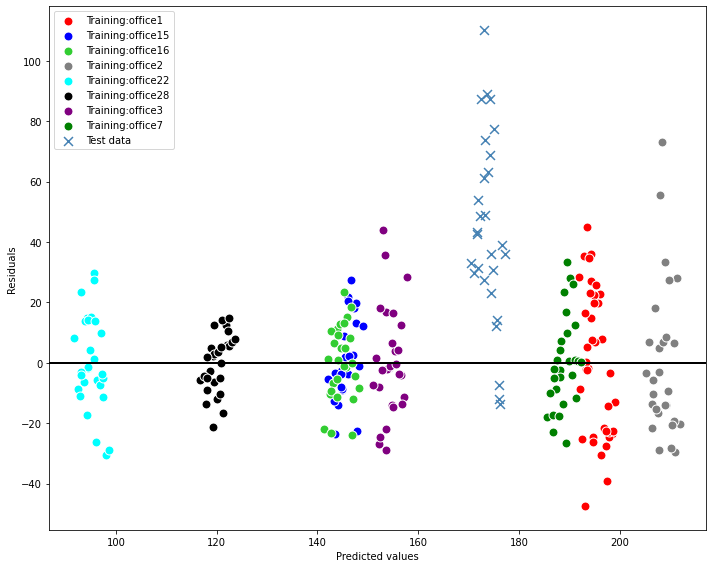

In [63]:
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()

show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy(), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy(), 
                            office_list=office_list)

### optunaと交差検証を使用したハイパーパラメータ調整（自動最適化）

In [72]:
class Objective:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        params = {
            "alpha" : trial.suggest_loguniform("alpha", 0.0001, 10),
            "max_iter" : trial.suggest_int("max_iter", 100, 100000),
            "solver" : "auto",
            "positive" : False
        }
        
        #**keywardargs(可変個数の変数をkeyと共に与えられる)
        model = Ridge(**params)
        
        #最適化実行時の評価指標の決定
        metrics = ["r2"]
        
        #交差検証の分割方法を決定
        kf = KFold(n_splits=10, shuffle=True, random_state=1)
        
        #評価指標の決定，k分割交差検証の実装
        scores = cross_validate(estimator=model, scoring=metrics,
                         X=self.X, y=self.y, 
                         cv=kf, n_jobs=1, verbose=0, return_train_score=True)
        
        return scores["test_r2"].mean()

In [73]:
control_log = ControlLog()
sqlite_path = control_log.set_log()
study_name = control_log.decide_filename()
model_name = "Ridge"

#ハイパーパラメータの探索
objective = Objective(X=train_explanatory_variable, y=train_objective_variable)

#計算資源があるときはランダムサーチ，無ければTPESampler
#storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                            sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                            storage=sqlite_path, load_if_exists=True)

"""
複数の目的関数を持つときはmulti_objectiveモジュールを使用する
複数の目的関数を最適化するのは多目的最適化と呼ばれ，専用の最適化アルゴリズムを指定する必要がある．単一目的関数の場合と比較する必要があるかもしれない．
directionは目的関数がどうなるように最適化したいか．samplerが多目的最適化アルゴリズム．defaultはNSGAIIMultiObjectiveSampler
"""

# study = optuna.multi_objective.create_study(directions=["maximize", "minimize"],
#                                             sampler=optuna.multi_objective.samplers.NSGAIIMultiObjectiveSampler(seed=1), 
#                                             storage=sqlite_path, load_if_exists=True)

#最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
#n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
study.optimize(objective, n_trials=None, timeout=60, n_jobs=-1)

#ハンドラの削除．これを行わないとログファイルが上書きされる．
control_log.kill_handler()

現在のログレベル: 20
SQLite file path: sqlite:///./OptunaLogs/2022-10-24/optuna.sqlite3


In [74]:
#探索の結果最も良かったscore
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

best score: 0.7726025237206751
best params: {'alpha': 5.6739554776167935, 'max_iter': 23214}


r2 train score:0.8128875221369013
MSE train score:308.4183869907359
r2 test score:-1.9418367842313424
MSE test score:2865.686497304446


/mnt/MachineLearning/modules/show_mod.py:88: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


<Figure size 720x576 with 0 Axes>

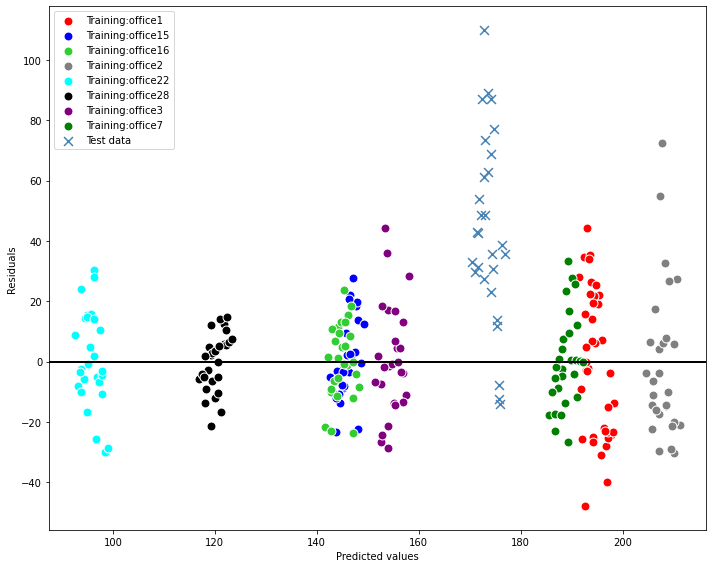

In [76]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価

best_model = Ridge(alpha=study.best_params["alpha"], max_iter=study.best_params["max_iter"])
best_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print(f"r2 train score:{best_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{best_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")


#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果の残差プロット
show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy(), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy(), 
                            office_list=office_list)

## ElasticNet

In [ ]:
#エラスティックネットのインスタンス作成
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5)）

In [ ]:
#k分割交差検証の実装
#評価指標の決定
metrics = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error"]
#交差検証の分割方法を決定
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [ ]:
scores = cross_validate(estimator=elasticnet_model, scoring=metrics,
                         X=train_explanatory_variable, y=train_objective_variable, 
                         cv=kf, n_jobs=1, verbose=1, return_train_score=True)
pprint.pprint(scores)

In [ ]:
print("交差検証結果の平均値")
print("test_r2 score:", scores["test_r2"].mean())
print("test_neg_mean_squared_error:", scores["test_neg_mean_squared_error"].mean())
print("test_neg_mean_absolute_error:", scores["test_neg_mean_absolute_error"].mean())

In [ ]:
elasticnet_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = elasticnet_model.predict(train_explanatory_variable)
test_pred = elasticnet_model.predict(test_explanatory_variable)

In [ ]:
#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()

show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy().reshape(-1), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy().reshape(-1), 
                            office_list=office_list)

# 多項式回帰

## 多項式線形重回帰

In [27]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]
train_explanatory_variable
# test_objective_variable

,aircon,ventilation,1_x,1_y,1_angle,2_x,2_y,2_angle,3_x,3_y,...,4_y,4_angle,5_x,5_y,5_angle,office_size_x,office_size_y,exhaust_a,exhaust_b,exhaust_off
office22_360_164_bout,-0.389955,0.294952,-0.007740,1.436811,1.877915,0.870156,1.856880,0.774494,-0.698828,-1.71394,...,-0.134961,-0.124274,2.054556,0.247300,-0.124274,0.73679,1.411927,-0.874700,1.143249,-0.391802
office22_660_246_aout,0.435795,1.276880,-0.007740,1.436811,1.877915,0.870156,1.856880,0.774494,-0.698828,-1.71394,...,-0.134961,-0.124274,2.054556,0.247300,-0.124274,0.73679,1.411927,1.143249,-0.874700,-0.391802
office22_660_82_bout,0.435795,-0.686976,-0.007740,1.436811,1.877915,0.870156,1.856880,0.774494,-0.698828,-1.71394,...,-0.134961,-0.124274,2.054556,0.247300,-0.124274,0.73679,1.411927,-0.874700,1.143249,-0.391802
office22_660_82_aout,0.435795,-0.686976,-0.007740,1.436811,1.877915,0.870156,1.856880,0.774494,-0.698828,-1.71394,...,-0.134961,-0.124274,2.054556,0.247300,-0.124274,0.73679,1.411927,1.143249,-0.874700,-0.391802
office22_660_164_bout,0.435795,0.294952,-0.007740,1.436811,1.877915,0.870156,1.856880,0.774494,-0.698828,-1.71394,...,-0.134961,-0.124274,2.054556,0.247300,-0.124274,0.73679,1.411927,-0.874700,1.143249,-0.391802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
office2_960_164_bout,1.261546,0.294952,0.097193,-1.294097,0.058793,0.638155,-0.717575,-0.033807,0.775102,1.02123,...,1.638603,-1.291561,-0.075483,0.950827,-1.291561,-1.08784,-0.079385,-0.874700,1.143249,-0.391802
office2_360_246_aout,-0.389955,1.276880,0.097193,-1.294097,0.058793,0.638155,-0.717575,-0.033807,0.775102,1.02123,...,1.638603,-1.291561,-0.075483,0.950827,-1.291561,-1.08784,-0.079385,1.143249,-0.874700,-0.391802
office2_360_164_bout,-0.389955,0.294952,0.097193,-1.294097,0.058793,0.638155,-0.717575,-0.033807,0.775102,1.02123,...,1.638603,-1.291561,-0.075483,0.950827,-1.291561,-1.08784,-0.079385,-0.874700,1.143249,-0.391802
office2_660_0,0.435795,-1.668904,0.097193,-1.294097,0.058793,0.638155,-0.717575,-0.033807,0.775102,1.02123,...,1.638603,-1.291561,-0.075483,0.950827,-1.291561,-1.08784,-0.079385,-0.874700,-0.874700,2.552310


In [50]:
#パイプラインの構築，attributeにアクセスできなくなったりするので使わない．やっぱ使う
def PolynomialRegression(n_components, degree, **kwargs):
    return make_pipeline(PCA(n_components=n_components), preprocessing.PolynomialFeatures(degree=degree), LinearRegression(**kwargs))

In [29]:
#各主成分の分散説明率
pca = PCA(n_components=None)
pca.fit(train_explanatory_variable)
pca.explained_variance_ratio_

array([2.42638739e-01, 1.88659142e-01, 1.28082574e-01, 8.62461663e-02,
       8.02346102e-02, 7.71319804e-02, 7.41337997e-02, 4.47719013e-02,
       4.26412970e-02, 1.93292418e-02, 1.61305485e-02, 8.03690699e-33,
       6.00301360e-33, 5.07301323e-33, 2.66212811e-33, 2.16698353e-33,
       2.06501841e-33, 1.22456034e-33, 5.70216982e-34, 3.99458296e-34,
       3.12994028e-34, 7.81155564e-68])

メモ：\
説明変数の数が22個もある．このまま多項式化しようとすると，項数が多すぎてメモリエラーとなり実行できない．（いけてdegree=5くらい）\
そのため説明変数を主成分分析によって減らした後，多項式回帰を実装してみようと思う．\
分散説明率の値からデータに大きく寄与しているのは大体11個位の成分なのでn_components=11でやってみる

In [31]:
#多項式化したときの大きさを確認
degree = 10
poly_model = preprocessing.PolynomialFeatures(degree=degree)
train_explanatory_variable_pca_poly = poly_model.fit_transform(train_explanatory_variable_pca)
train_explanatory_variable_pca_poly.shape

(235, 352716)

In [ ]:
#多項式化したときの項を確認
poly_model.get_feature_names(train_explanatory_variable.columns)

In [35]:
pca = PCA(n_components=11)
pca.fit(train_explanatory_variable)
train_explanatory_variable_pca = pd.DataFrame(pca.transform(train_explanatory_variable))

In [51]:
class Objective:
    def __init__(self, X, y):
        #oputunaの最適化実行時に元データをそのまま参照しているとメモリの開放ができない
        self.X = X
        self.y = y
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        n_components = trial.suggest_int("n_components", 1, 11)
        degree = trial.suggest_int("degree", 1, 5)#*argsにはiterableオブジェクトつまり，繰り返しができるtupleの形で与える必要がある
#         kwargs = {
#         }

        model = PolynomialRegression(n_components=n_components, degree=degree)
        
        #最適化実行時の評価指標の決定
        metrics = ["r2"]
        
        #交差検証の分割方法を決定
        kf = KFold(n_splits=10, shuffle=True, random_state=1)
        
        #評価指標の決定，k分割交差検証の実装
        scores = cross_validate(estimator=model, scoring=metrics,
                         X=self.X, y=self.y, 
                         cv=kf, n_jobs=1, verbose=0, return_train_score=False)
        
        return scores["test_r2"].mean()

In [52]:
control_log = ControlLog()
sqlite_path = control_log.set_log()
study_name = control_log.decide_filename()
model_name = "Poly_Linear"

#ハイパーパラメータの探索
objective = Objective(X=train_explanatory_variable, y=train_objective_variable)

#計算資源があるときはランダムサーチ，無ければTPESampler
#storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                            sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                            storage=sqlite_path, load_if_exists=True)

print(f"sutdy name: {study_name[0]}")

#最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
#n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
study.optimize(objective, n_trials=None, timeout=120, n_jobs=-1)
# study.optimize(objective, n_trials=10000, timeout=None, n_jobs=5)

#ハンドラの削除．これを行わないとログファイルが上書きされる．
control_log.kill_handler()

現在のログレベル: 20
SQLite file path: sqlite:///./OptunaLogs/2022-10-26/optuna.sqlite3
sutdy name: 7541


In [53]:
#探索の結果最も良かったscore
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

best score: 0.8159418543986735
best params: {'degree': 2, 'n_components': 11}


r2 train score:0.8699417925499029
MSE train score:214.37556177313698
r2 test score:-6.390542252066639e+26
MSE test score:6.225121237304094e+29


/mnt/MachineLearning/modules/show_mod.py:88: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


<Figure size 720x576 with 0 Axes>

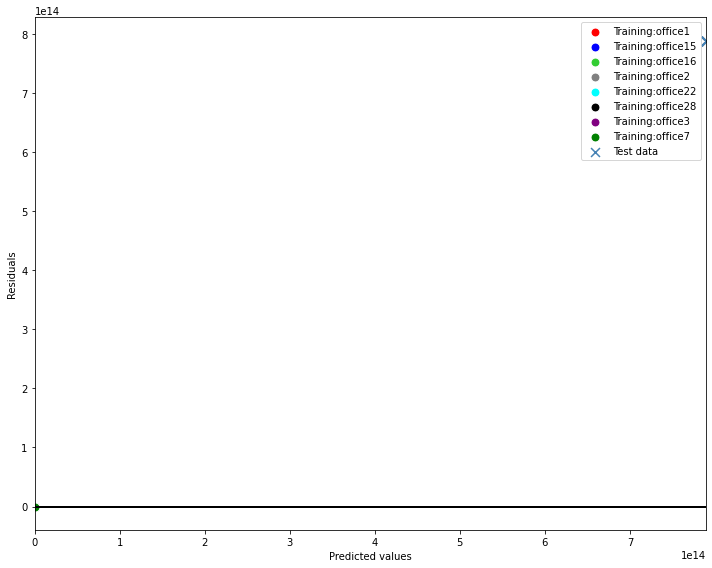

In [58]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価

best_model = PolynomialRegression(n_components=study.best_params["n_components"], degree=study.best_params["degree"])
best_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print(f"r2 train score:{best_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{best_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")


#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果の残差プロット
show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy(), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy(), 
                            office_list=office_list)

超過学習．テストデータには一切適応できず．\
データ数を増やす，同じオフィス形状だけで試すなどすれば改善する可能性あり

## Lasso

In [34]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]
test_explanatory_variable
test_objective_variable

,RoI
office10_360_164_bout,97.747619
office10_660_246_aout,124.204762
office10_660_82_bout,111.785714
office10_660_82_aout,117.776190
office10_660_164_bout,84.561905
office10_0_164_aout,163.342857
office10_0_82_aout,143.985714
office10_660_164_aout,85.161905
office10_660_246_bout,87.109524
office10_360_246_bout,161.519048


In [35]:
#パイプラインの構築
def LassoRegression(n_components, degree, **kwargs):
    return make_pipeline(PCA(n_components=n_components), preprocessing.PolynomialFeatures(degree=degree), Lasso(**kwargs))

In [36]:
class Objective:
    
    def __init__(self, X, y, n_trials):
        self.X = X
        self.y = y
        self.bar = tqdm(total = n_trials)
        self.bar.set_description('Progress rate')
        
    def __call__(self, trial):
        #ハイパーパラメータの値設定
        n_components = trial.suggest_int("n_components", 1, 11)
        degree = trial.suggest_int("degree", 1, 5)#*argsにはiterableオブジェクトつまり，繰り返しができるtupleの形で与える必要がある
        kwargs = {
            "alpha" : trial.suggest_loguniform("alpha", 0.0001, 10),
            "max_iter" : trial.suggest_int("max_iter", 100, 100000)
        }
        
        #**keywardargs(可変個数の変数をkeyと共に与えられる)
        model = LassoRegression(n_components=n_components, degree=degree, **kwargs)
        
        #最適化実行時の評価指標の決定
        metrics = ["r2"]
        
        #交差検証の分割方法を決定
        kf = KFold(n_splits=10, shuffle=True, random_state=1)
        
        #評価指標の決定，k分割交差検証の実装
        scores = cross_validate(estimator=model, scoring=metrics,
                         X=self.X, y=self.y, 
                         cv=kf, n_jobs=1, verbose=0, return_train_score=False)
        
        self.bar.update(1)
        
        return scores["test_r2"].mean()

In [38]:
control_log = ControlLog()
sqlite_path = control_log.set_log()
study_name = control_log.decide_filename()
model_name = "Poly_Lasso"

#訓練時のパラメータ設定
n_trials=20
timeout=None
n_jobs=-1

"""
最後のcontrol_log.kill_handler()が回らないとログが不必要に上書きされるので例外処理で最後まで必ず回るようにする．
exceptがtry内でエラーが生じたときの処理内容
finallyはtry内でエラーが生じたとき，生じなかったときどちらも動く処理
"""
try:
    #ハイパーパラメータの探索
    objective = Objective(X=train_explanatory_variable, y=train_objective_variable, n_trials=n_trials)

    #計算資源があるときはランダムサーチ，無ければTPESampler
    #storageのパスにすでにDBファイルがあれば，それを読み込むのがload_if_exists
    study = optuna.create_study(directions=["maximize"], study_name=model_name+"_"+study_name[0],
                                sampler=optuna.samplers.RandomSampler(), pruner=optuna.pruners.MedianPruner(),
                                storage=sqlite_path, load_if_exists=True)

    print(f"study name: {study_name[0]}")

    #最適化の実行．n_trialsは何回実行するか．指定しなければできるだけやる．他にもtimeoutは計算にかける時間の上限値を秒単位で指定できる
    #n_trialsまたはtimeoutのどちらかは指定したほうが良い．でないと永遠に計算し続け，pcが重くなる．
    study.optimize(objective, n_trials=n_trials, timeout=timeout, n_jobs=n_jobs)

except Exception as error:
    print(error)

finally:
    #ハンドラの削除．これを行わないとログファイルが上書きされる．
    control_log.kill_handler()

現在のログレベル: 20
SQLite file path: sqlite:///./OptunaLogs/2022-10-27/optuna.sqlite3


  0%|          | 0/20 [00:00<?, ?it/s]

study name: 32653


In [66]:
#探索の結果最も良かったscoreとパラメータの表示
print(f"best score: {study.best_value}")
print(f"best params: {study.best_params}")

best score: 0.8288959214076558
best params: {'alpha': 1.5225586908025392, 'degree': 3, 'max_iter': 44024, 'n_components': 11}


r2 train score:0.8792631798134068
MSE train score:199.01107482305088
r2 test score:-3.0759594585141414
MSE test score:3970.4520816494696


/mnt/MachineLearning/modules/show_mod.py:88: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(test_x, test_y, s=80, c="steelblue", marker="x", edgecolor="white", label="Test data")


<Figure size 720x576 with 0 Axes>

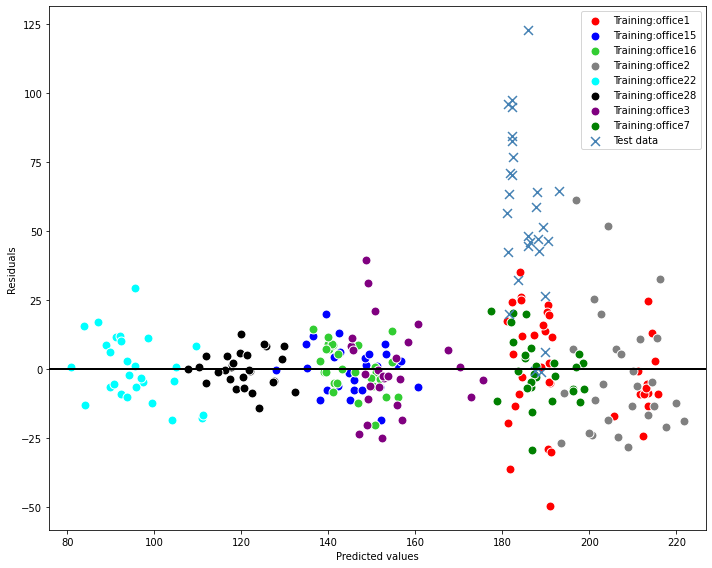

In [68]:
#決定したハイパーパラメータを使用して全訓練データで学習，評価

best_model = LassoRegression(n_components=study.best_params["n_components"], degree=study.best_params["degree"], 
                             alpha=study.best_params["alpha"], max_iter=study.best_params["max_iter"])
best_model.fit(train_explanatory_variable, train_objective_variable)
train_pred = best_model.predict(train_explanatory_variable)
test_pred = best_model.predict(test_explanatory_variable)
print(f"r2 train score:{best_model.score(train_explanatory_variable, train_objective_variable)}")
print(f"MSE train score:{mean_squared_error(train_objective_variable, train_pred)}")
print(f"r2 test score:{best_model.score(test_explanatory_variable, test_objective_variable)}")
print(f"MSE test score:{mean_squared_error(test_objective_variable, test_pred)}")


#正規表現で書いており、.extractはパターンにマッチした最初の文字列のみを抜き出す。office+0-9までの数字1桁または2桁を探索
office_list = train_objective_variable.index.str.extract("(office+[0-9]{1,2})").to_numpy()
#予測結果の残差プロット
show_mod.show_office_residual_plot(train_x=train_pred, train_y=train_pred-train_objective_variable.to_numpy().reshape(-1), 
                            test_x=test_pred, test_y=test_pred-test_objective_variable.to_numpy().reshape(-1), 
                            office_list=office_list)

トレーニングデータに関するフィッティングはかなり良くなっている\
しかしテストデータに関してはまだ厳しい

5

## Ridge

In [ ]:
#使用するデータセットの決定（標準化するか否かなど）
#トレーニングデータ、テストデータの振り分け
train_explanatory_variable = df_explanatory_variable_std.iloc[train_data_index]
test_explanatory_variable = df_explanatory_variable_std.iloc[test_data_index]
train_objective_variable = df_objective_variable.iloc[train_data_index]
test_objective_variable = df_objective_variable.iloc[test_data_index]
test_explanatory_variable
test_objective_variable

# サポートベクター回帰

### todo
* データ数とバイアス，バリアンスの関係を評価（データ数の問題がわかる可能性あり）
* 学習曲線の描画(optuna-dashboardを使用するとなるとsqliteの勉強が必要)
* MSE等の評価指標の取得は最終的な訓練後だけでいいかなと思っている（最適化中はいらないかな）
* 座標の対称移動などによるデータ数の増加はやってみる価値あり